
# Прогноз цены каучука
В этой задаче вам предстоит предсказать будущие котировки натурального каучука - естественного конкурента синтетического каучука, который производит компания СИБУР.

Для построения моделей вам доступны исторические данные: курсы валют, цены на нефть марки Brent и дневные котировки натурального каучука. Целевой переменной является средняя месячная котировка натурального каучука, при этом прогноз должен строиться на основании данных, доступных до 10-го числа предыдущего месяца.

Например, последняя дата, которую можно использовать для прогноза на февраль - 9-е января. Точный набор дат, для которых необходимо построить прогноз, доступен в файле rubber_test_timestamps.csv.

Данные
Крупнейшими производителями натурального каучука являются Таиланд, Индонезия и Вьетнам. Курсы валют этих стран напрямую связаны с котировками на каучук: при росте валюты по отношению к доллару США может происходить снижение цены на каучук, поскольку внутреннее производство привязано к национальным валютам.

С другой стороны, крупнейшим потребителем натурального каучука является Китай, поэтому курс юаня также может влиять на долларовую цену каучука, но в обратном направлении.

Цена на нефть не влияет на котировки каучука напрямую, но может влиять косвенно через стоимость транспортировки.

Исторические дневные курсы (цена открытия, максимальная, минимальная и средняя) валют стран-производителей и Китая и цены на нефть содержатся в файле rubber_daily.csv. Целевая переменная для тренировочного периода (с августа 2002 по декабрь 2015) доступна в файле rubber_target_train.csv.

Базовое решение
Простой линейный baseline доступен в ноутбуке Baseline - Rubber.ipynb. Он воспроизводит тривиальное решение rubber_naive_baseline.csv (последнее известное значение тренировочного периода) и создает решение на основе простой линейной модели.

### Уважаемые организаторы! Данный ноутбук можно проверять на обычном ПК - время выполнения кода около 5 минут.

In [1]:
import numpy as np

import pandas as pd

import seaborn as sns

from sklearn import linear_model, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, \
                                    cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('rubber_daily.csv', header = 0, sep = ',')
test_target = pd.read_csv('rubber_test_timestamps.csv', header = 0, sep = ',')
train_target = pd.read_csv('rubber_target_train.csv', header = 0, sep = ',')

In [4]:
data.head(-1)

,date,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,USDTHB_mid,...,USDTHB_open,USDIDR_mid,USDIDR_max,USDIDR_min,USDIDR_open,USDVND_mid,USDVND_max,USDVND_min,USDVND_open,rubber_close
0,2002-07-01,25.64,25.50,25.72,25.39,8.2770,8.2770,8.2770,8.2770,41.570,...,41.50,8710.0,8715.0,8669.0,8700.0,15297.5,NaN,NaN,NaN,835.0
1,2002-07-02,25.75,25.61,25.97,25.60,8.2769,8.2769,8.2769,8.2769,41.515,...,41.54,8805.0,8820.0,8720.0,8720.0,15297.0,NaN,NaN,NaN,827.5
2,2002-07-03,25.84,25.73,25.96,25.52,8.2768,8.2768,8.2768,8.2768,41.610,...,41.53,8965.0,8985.0,8790.0,8825.0,15297.5,NaN,NaN,NaN,847.5
3,2002-07-04,25.55,25.88,25.94,25.50,8.2767,8.2767,8.2767,8.2767,41.545,...,41.50,8855.0,8970.0,8790.0,8790.0,15298.5,NaN,NaN,NaN,847.5
4,2002-07-05,25.73,25.65,25.75,25.42,8.2766,8.2766,8.2766,8.2766,41.645,...,41.56,8860.0,8850.0,8815.0,8830.0,15295.0,NaN,NaN,NaN,847.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4215,2019-06-21,65.20,64.86,65.76,64.00,6.8700,6.8524,6.8793,6.8336,30.795,...,30.85,14155.0,14165.0,14075.0,14120.0,23290.0,23295.0,23280.0,23290.0,1479.0
4216,2019-06-24,64.86,65.50,65.79,64.08,6.8770,6.8736,6.8873,6.8700,30.665,...,30.81,14140.0,14170.0,14130.0,14130.0,23291.0,23300.0,23280.0,23290.0,1469.0
4217,2019-06-25,65.05,64.89,65.98,64.17,6.8798,6.8715,6.8851,6.8655,30.710,...,30.66,14125.0,14140.0,14090.0,14135.0,23297.0,23305.0,23284.0,23290.0,1495.0
4218,2019-06-26,66.49,65.80,66.85,65.60,6.8800,6.8876,6.8937,6.8658,30.735,...,30.76,14175.0,14180.0,14130.0,14130.0,23305.0,23320.0,23287.0,23300.0,1498.0


In [5]:
data.corr()

,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,USDTHB_mid,USDTHB_max,...,USDTHB_open,USDIDR_mid,USDIDR_max,USDIDR_min,USDIDR_open,USDVND_mid,USDVND_max,USDVND_min,USDVND_open,rubber_close
brent_close,1.000000,0.998912,0.999474,0.999573,-0.623703,-0.623357,-0.624026,-0.623054,-0.760177,-0.765801,...,-0.763963,-0.146723,-0.138406,-0.134919,-0.137160,0.292629,-0.203942,-0.204090,-0.204223,0.761726
brent_open,0.998912,1.000000,0.999537,0.999434,-0.624478,-0.624166,-0.624816,-0.623849,-0.759620,-0.765575,...,-0.763619,-0.145793,-0.137589,-0.134156,-0.136420,0.292782,-0.206895,-0.207023,-0.207196,0.760855
brent_max,0.999474,0.999537,1.000000,0.999313,-0.624896,-0.624566,-0.625216,-0.624262,-0.760611,-0.766405,...,-0.764494,-0.146166,-0.137794,-0.134436,-0.136642,0.291210,-0.213424,-0.213557,-0.213724,0.762800
brent_min,0.999573,0.999434,0.999313,1.000000,-0.623315,-0.622976,-0.623648,-0.622667,-0.759093,-0.764846,...,-0.762933,-0.145892,-0.137740,-0.134199,-0.136468,0.294262,-0.197091,-0.197235,-0.197370,0.759753
USDCNY_close,-0.623703,-0.624478,-0.624896,-0.623315,1.000000,0.999940,0.999964,0.999969,0.848667,0.879317,...,0.865264,-0.495599,-0.500091,-0.502164,-0.500561,-0.828901,-0.211493,-0.214746,-0.211248,-0.410354
USDCNY_open,-0.623357,-0.624166,-0.624566,-0.622976,0.999940,1.000000,0.999962,0.999965,0.848284,0.879009,...,0.864974,-0.496071,-0.500555,-0.502615,-0.501004,-0.829103,-0.211700,-0.214966,-0.211437,-0.409978
USDCNY_max,-0.624026,-0.624816,-0.625216,-0.623648,0.999964,0.999962,1.000000,0.999935,0.848021,0.878773,...,0.864704,-0.493854,-0.498369,-0.500436,-0.498831,-0.827842,-0.204004,-0.207198,-0.203744,-0.410713
USDCNY_min,-0.623054,-0.623849,-0.624262,-0.622667,0.999969,0.999965,0.999935,1.000000,0.848903,0.879538,...,0.865509,-0.497570,-0.502026,-0.504096,-0.502489,-0.830058,-0.218563,-0.221884,-0.218317,-0.409642
USDTHB_mid,-0.760177,-0.759620,-0.760611,-0.759093,0.848667,0.848284,0.848021,0.848903,1.000000,0.990828,...,0.994562,-0.241475,-0.245136,-0.249782,-0.246954,-0.637014,0.000955,0.003610,0.001011,-0.630097
USDTHB_max,-0.765801,-0.765575,-0.766405,-0.764846,0.879317,0.879009,0.878773,0.879538,0.990828,1.000000,...,0.995330,-0.265125,-0.268667,-0.273296,-0.270437,-0.676770,0.004594,0.007233,0.004631,-0.633217


In [6]:
data.columns

Index(['date', 'brent_close', 'brent_open', 'brent_max', 'brent_min',
       'USDCNY_close', 'USDCNY_open', 'USDCNY_max', 'USDCNY_min', 'USDTHB_mid',
       'USDTHB_max', 'USDTHB_min', 'USDTHB_open', 'USDIDR_mid', 'USDIDR_max',
       'USDIDR_min', 'USDIDR_open', 'USDVND_mid', 'USDVND_max', 'USDVND_min',
       'USDVND_open', 'rubber_close'],
      dtype='object')

In [7]:
print(data.shape)

(4221, 22)


In [8]:
data.isnull().values.any()

True

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4221 entries, 0 to 4220
Data columns (total 22 columns):
date            4221 non-null object
brent_close     4221 non-null float64
brent_open      4221 non-null float64
brent_max       4221 non-null float64
brent_min       4221 non-null float64
USDCNY_close    4221 non-null float64
USDCNY_open     4221 non-null float64
USDCNY_max      4221 non-null float64
USDCNY_min      4221 non-null float64
USDTHB_mid      4221 non-null float64
USDTHB_max      4220 non-null float64
USDTHB_min      4220 non-null float64
USDTHB_open     4220 non-null float64
USDIDR_mid      4219 non-null float64
USDIDR_max      4092 non-null float64
USDIDR_min      4092 non-null float64
USDIDR_open     4091 non-null float64
USDVND_mid      4209 non-null float64
USDVND_max      2675 non-null float64
USDVND_min      2675 non-null float64
USDVND_open     2674 non-null float64
rubber_close    4221 non-null float64
dtypes: float64(21), object(1)
memory usage: 725.6+ KB


In [10]:
test_target.head()

,date
0,2016-01-01
1,2016-02-01
2,2016-03-01
3,2016-04-01
4,2016-05-01


In [11]:
test_target.shape

(42, 1)

In [12]:
train_target.head(-1)

,date,rubber
0,2002-08-01,830.595238
1,2002-09-01,895.476190
2,2002-10-01,831.304348
3,2002-11-01,840.250000
4,2002-12-01,849.875000
...,...,...
155,2015-07-01,1453.772727
156,2015-08-01,1319.947368
157,2015-09-01,1247.200000
158,2015-10-01,1252.136364


In [13]:
train_target.shape

(161, 2)

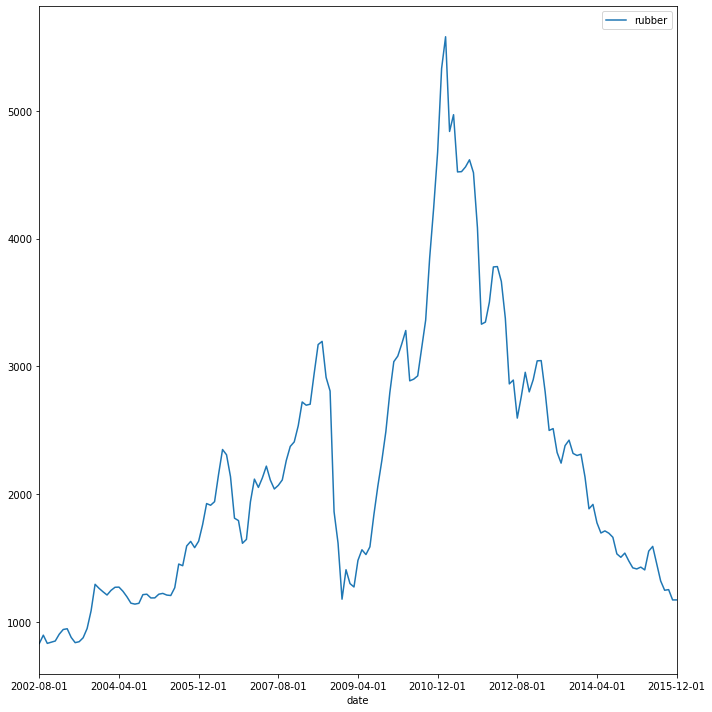

In [14]:
plt.rcParams["figure.figsize"] = (10,10)

train_target.plot('date', 'rubber')

# Rotate and align xtick labels
#ax.get_figure().autofmt_xdate()

# make room for tick labels
plt.tight_layout()


plt.show()

## Предобработка данных

In [15]:
NaNList = []
for i in range(0, data.shape[0]):
    for k in range(0,data.shape[1]):
        if data.iloc[[i], [k]].isnull().bool():
              NaNList.append(k)

print(len(NaNList))

5044


Пропущенные значения составляют 5,43 %

In [16]:
for i in range(0, data.shape[1]):
    c=0
    for k in NaNList:
        if i == k:
            c = c + 1
    print ('column number ={0},  amount of NaN = {1} '.format(i, c))

column number =0,  amount of NaN = 0 
column number =1,  amount of NaN = 0 
column number =2,  amount of NaN = 0 
column number =3,  amount of NaN = 0 
column number =4,  amount of NaN = 0 
column number =5,  amount of NaN = 0 
column number =6,  amount of NaN = 0 
column number =7,  amount of NaN = 0 
column number =8,  amount of NaN = 0 
column number =9,  amount of NaN = 0 
column number =10,  amount of NaN = 1 
column number =11,  amount of NaN = 1 
column number =12,  amount of NaN = 1 
column number =13,  amount of NaN = 2 
column number =14,  amount of NaN = 129 
column number =15,  amount of NaN = 129 
column number =16,  amount of NaN = 130 
column number =17,  amount of NaN = 12 
column number =18,  amount of NaN = 1546 
column number =19,  amount of NaN = 1546 
column number =20,  amount of NaN = 1547 
column number =21,  amount of NaN = 0 


In [17]:
data.drop(data.columns[[18,19,20]], axis=1, inplace=True)

In [18]:
data.shape

(4221, 19)

In [19]:
data.head()

,date,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,USDTHB_mid,USDTHB_max,USDTHB_min,USDTHB_open,USDIDR_mid,USDIDR_max,USDIDR_min,USDIDR_open,USDVND_mid,rubber_close
0,2002-07-01,25.64,25.50,25.72,25.39,8.2770,8.2770,8.2770,8.2770,41.570,41.570,41.395,41.50,8710.0,8715.0,8669.0,8700.0,15297.5,835.0
1,2002-07-02,25.75,25.61,25.97,25.60,8.2769,8.2769,8.2769,8.2769,41.515,41.560,41.420,41.54,8805.0,8820.0,8720.0,8720.0,15297.0,827.5
2,2002-07-03,25.84,25.73,25.96,25.52,8.2768,8.2768,8.2768,8.2768,41.610,41.645,41.520,41.53,8965.0,8985.0,8790.0,8825.0,15297.5,847.5
3,2002-07-04,25.55,25.88,25.94,25.50,8.2767,8.2767,8.2767,8.2767,41.545,41.620,41.495,41.50,8855.0,8970.0,8790.0,8790.0,15298.5,847.5
4,2002-07-05,25.73,25.65,25.75,25.42,8.2766,8.2766,8.2766,8.2766,41.645,41.640,41.515,41.56,8860.0,8850.0,8815.0,8830.0,15295.0,847.5


In [20]:
yearList =[]
for i in data['date']:
    yearList.append(int(str(i)[-10:-6]))
    
monthList =[]
for i in data['date']:
    monthList.append(int(str(i)[-5:-3]))

In [21]:
data['Year'] = yearList
data['Month'] = monthList

In [22]:
data.drop('date', axis=1, inplace=True)

In [23]:
data.head(-1)

,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,USDTHB_mid,USDTHB_max,USDTHB_min,USDTHB_open,USDIDR_mid,USDIDR_max,USDIDR_min,USDIDR_open,USDVND_mid,rubber_close,Year,Month
0,25.64,25.50,25.72,25.39,8.2770,8.2770,8.2770,8.2770,41.570,41.570,41.395,41.50,8710.0,8715.0,8669.0,8700.0,15297.5,835.0,2002,7
1,25.75,25.61,25.97,25.60,8.2769,8.2769,8.2769,8.2769,41.515,41.560,41.420,41.54,8805.0,8820.0,8720.0,8720.0,15297.0,827.5,2002,7
2,25.84,25.73,25.96,25.52,8.2768,8.2768,8.2768,8.2768,41.610,41.645,41.520,41.53,8965.0,8985.0,8790.0,8825.0,15297.5,847.5,2002,7
3,25.55,25.88,25.94,25.50,8.2767,8.2767,8.2767,8.2767,41.545,41.620,41.495,41.50,8855.0,8970.0,8790.0,8790.0,15298.5,847.5,2002,7
4,25.73,25.65,25.75,25.42,8.2766,8.2766,8.2766,8.2766,41.645,41.640,41.515,41.56,8860.0,8850.0,8815.0,8830.0,15295.0,847.5,2002,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4215,65.20,64.86,65.76,64.00,6.8700,6.8524,6.8793,6.8336,30.795,30.890,30.760,30.85,14155.0,14165.0,14075.0,14120.0,23290.0,1479.0,2019,6
4216,64.86,65.50,65.79,64.08,6.8770,6.8736,6.8873,6.8700,30.665,30.820,30.650,30.81,14140.0,14170.0,14130.0,14130.0,23291.0,1469.0,2019,6
4217,65.05,64.89,65.98,64.17,6.8798,6.8715,6.8851,6.8655,30.710,30.750,30.620,30.66,14125.0,14140.0,14090.0,14135.0,23297.0,1495.0,2019,6
4218,66.49,65.80,66.85,65.60,6.8800,6.8876,6.8937,6.8658,30.735,30.870,30.700,30.76,14175.0,14180.0,14130.0,14130.0,23305.0,1498.0,2019,6


In [24]:
data.shape

(4221, 20)

In [25]:
[i + '_MEAN' for i in data.columns]

['brent_close_MEAN',
 'brent_open_MEAN',
 'brent_max_MEAN',
 'brent_min_MEAN',
 'USDCNY_close_MEAN',
 'USDCNY_open_MEAN',
 'USDCNY_max_MEAN',
 'USDCNY_min_MEAN',
 'USDTHB_mid_MEAN',
 'USDTHB_max_MEAN',
 'USDTHB_min_MEAN',
 'USDTHB_open_MEAN',
 'USDIDR_mid_MEAN',
 'USDIDR_max_MEAN',
 'USDIDR_min_MEAN',
 'USDIDR_open_MEAN',
 'USDVND_mid_MEAN',
 'rubber_close_MEAN',
 'Year_MEAN',
 'Month_MEAN']

In [26]:
train_data = pd.DataFrame({'brent_close_MEAN':[],
 'brent_open_MEAN':[],
 'brent_max_MEAN':[],
 'brent_min_MEAN':[],
 'USDCNY_close_MEAN':[],
 'USDCNY_open_MEAN':[],
 'USDCNY_max_MEAN':[],
 'USDCNY_min_MEAN':[],
 'USDTHB_mid_MEAN':[],
 'USDTHB_max_MEAN':[],
 'USDTHB_min_MEAN':[],
 'USDTHB_open_MEAN':[],
 'USDIDR_mid_MEAN':[],
 'USDIDR_max_MEAN':[],
 'USDIDR_min_MEAN':[],
 'USDIDR_open_MEAN':[],
 'USDVND_mid_MEAN':[],
 'rubber_close_MEAN':[],
 'brent_close_MAX':[],
 'brent_open_MAX':[],
 'brent_max_MAX':[],
 'brent_min_MAX':[],
 'USDCNY_close_MAX':[],
 'USDCNY_open_MAX':[],
 'USDCNY_max_MAX':[],
 'USDCNY_min_MAX':[],
 'USDTHB_mid_MAX':[],
 'USDTHB_max_MAX':[],
 'USDTHB_min_MAX':[],
 'USDTHB_open_MAX':[],
 'USDIDR_mid_MAX':[],
 'USDIDR_max_MAX':[],
 'USDIDR_min_MAX':[],
 'USDIDR_open_MAX':[],
 'USDVND_mid_MAX':[],
 'rubber_close_MAX':[],
 'brent_close_MIN':[],
 'brent_open_MIN':[],
 'brent_max_MIN':[],
 'brent_min_MIN':[],
 'USDCNY_close_MIN':[],
 'USDCNY_open_MIN':[],
 'USDCNY_max_MIN':[],
 'USDCNY_min_MIN':[],
 'USDTHB_mid_MIN':[],
 'USDTHB_max_MIN':[],
 'USDTHB_min_MIN':[],
 'USDTHB_open_MIN':[],
 'USDIDR_mid_MIN':[],
 'USDIDR_max_MIN':[],
 'USDIDR_min_MIN':[],
 'USDIDR_open_MIN':[],
 'USDVND_mid_MIN':[],
 'rubber_close_MIN':[],
 'brent_close_MEDIAN':[],
 'brent_open_MEDIAN':[],
 'brent_max_MEDIAN':[],
 'brent_min_MEDIAN':[],
 'USDCNY_close_MEDIAN':[],
 'USDCNY_open_MEDIAN':[],
 'USDCNY_max_MEDIAN':[],
 'USDCNY_min_MEDIAN':[],
 'USDTHB_mid_MEDIAN':[],
 'USDTHB_max_MEDIAN':[],
 'USDTHB_min_MEDIAN':[],
 'USDTHB_open_MEDIAN':[],
 'USDIDR_mid_MEDIAN':[],
 'USDIDR_max_MEDIAN':[],
 'USDIDR_min_MEDIAN':[],
 'USDIDR_open_MEDIAN':[],
 'USDVND_mid_MEDIAN':[],
 'rubber_close_MEDIAN':[],
 'Year_MEAN':[],
 'Month_MEAN':[]})

In [27]:
for m in range(2002, 2020):
    for n in range(1, 13):
        x = [ i for i in (data[(data.Year == m) & (data.Month == n)].mean(axis = 0))]
        y = [ i for i in (data[(data.Year == m) & (data.Month == n)].max(axis = 0))]
        z = [ i for i in (data[(data.Year == m) & (data.Month == n)].min(axis = 0))]
        k = [ i for i in (data[(data.Year == m) & (data.Month == n)].median(axis = 0))]
        new_line = {'brent_close_MEAN':x[0],
 'brent_open_MEAN':x[1],
 'brent_max_MEAN':x[2],
 'brent_min_MEAN':x[3],
 'USDCNY_close_MEAN':x[4],
 'USDCNY_open_MEAN':x[5],
 'USDCNY_max_MEAN':x[6],
 'USDCNY_min_MEAN':x[7],
 'USDTHB_mid_MEAN':x[8],
 'USDTHB_max_MEAN':x[9],
 'USDTHB_min_MEAN':x[10],
 'USDTHB_open_MEAN':x[11],
 'USDIDR_mid_MEAN':x[12],
 'USDIDR_max_MEAN':x[13],
 'USDIDR_min_MEAN':x[14],
 'USDIDR_open_MEAN':x[15],
 'USDVND_mid_MEAN':x[16],
'rubber_close_MEAN':x[17],
 'brent_close_MAX':y[0],
 'brent_open_MAX':y[1],
 'brent_max_MAX':y[2],
 'brent_min_MAX':y[3],
 'USDCNY_close_MAX':y[4],
 'USDCNY_open_MAX':y[5],
 'USDCNY_max_MAX':y[6],
 'USDCNY_min_MAX':y[7],
 'USDTHB_mid_MAX':y[8],
 'USDTHB_max_MAX':y[9],
 'USDTHB_min_MAX':y[10],
 'USDTHB_open_MAX':y[11],
 'USDIDR_mid_MAX':y[12],
 'USDIDR_max_MAX':y[13],
 'USDIDR_min_MAX':y[14],
 'USDIDR_open_MAX':y[15],
 'USDVND_mid_MAX':y[16],
 'rubber_close_MAX':y[17],
 'brent_close_MIN':z[0],
 'brent_open_MIN':z[1],
 'brent_max_MIN':z[2],
 'brent_min_MIN':z[3],
 'USDCNY_close_MIN':z[4],
 'USDCNY_open_MIN':z[5],
 'USDCNY_max_MIN':z[6],
 'USDCNY_min_MIN':z[7],
 'USDTHB_mid_MIN':z[8],
 'USDTHB_max_MIN':z[9],
 'USDTHB_min_MIN':z[10],
 'USDTHB_open_MIN':z[11],
 'USDIDR_mid_MIN':z[12],
 'USDIDR_max_MIN':z[13],
 'USDIDR_min_MIN':z[14],
 'USDIDR_open_MIN':z[15],
 'USDVND_mid_MIN':z[16],
 'rubber_close_MIN':z[17],
 'brent_close_MEDIAN':k[0],
 'brent_open_MEDIAN':k[1],
 'brent_max_MEDIAN':k[2],
 'brent_min_MEDIAN':k[3],
 'USDCNY_close_MEDIAN':k[4],
 'USDCNY_open_MEDIAN':k[5],
 'USDCNY_max_MEDIAN':k[6],
 'USDCNY_min_MEDIAN':k[7],
 'USDTHB_mid_MEDIAN':k[8],
 'USDTHB_max_MEDIAN':k[9],
 'USDTHB_min_MEDIAN':k[10],
 'USDTHB_open_MEDIAN':k[11],
 'USDIDR_mid_MEDIAN':k[12],
 'USDIDR_max_MEDIAN':k[13],
 'USDIDR_min_MEDIAN':k[14],
 'USDIDR_open_MEDIAN':k[15],
 'USDVND_mid_MEDIAN':k[16],
 'rubber_close_MEDIAN':k[17],
'Year_MEAN':x[18],
 'Month_MEAN':x[19]}
        train_data = train_data.append(new_line, ignore_index=True)

In [28]:
train_data.shape

(216, 74)

In [29]:
#train_data

In [30]:
NaNList = []
for i in range(0, train_data.shape[0]):
    for k in range(0,train_data.shape[1]):
        if train_data.iloc[[i], [73]].isnull().bool():
            NaNList.append(i)
            break
train_data.drop(NaNList, axis=0, inplace=True)
train_data = train_data.reset_index(drop=True)

In [31]:
train_data

,brent_close_MEAN,brent_open_MEAN,brent_max_MEAN,brent_min_MEAN,USDCNY_close_MEAN,USDCNY_open_MEAN,USDCNY_max_MEAN,USDCNY_min_MEAN,USDTHB_mid_MEAN,USDTHB_max_MEAN,...,USDTHB_min_MEDIAN,USDTHB_open_MEDIAN,USDIDR_mid_MEDIAN,USDIDR_max_MEDIAN,USDIDR_min_MEDIAN,USDIDR_open_MEDIAN,USDVND_mid_MEDIAN,rubber_close_MEDIAN,Year_MEAN,Month_MEAN
0,25.680870,25.663478,25.917826,25.394348,8.276796,8.276796,8.276796,8.276796,41.252609,41.360652,...,41.030,41.23,8965.00,9025.0,8815.0,8928.0,15298.0,812.5,2002.0,7.0
1,26.405500,26.307000,26.672500,26.056000,8.276730,8.276730,8.276730,8.276730,42.145750,42.250750,...,42.025,42.09,8877.50,8890.0,8835.0,8860.0,15325.0,832.5,2002.0,8.0
2,28.290476,28.297619,28.625238,28.000000,8.276986,8.276986,8.276986,8.276986,42.841190,42.895000,...,42.800,42.90,8994.00,9005.0,8940.0,8990.0,15334.0,890.0,2002.0,9.0
3,27.358261,27.471304,27.710435,27.105217,8.277039,8.277039,8.277039,8.277039,43.649130,43.714783,...,43.520,43.60,9194.00,9225.0,9015.0,9160.0,15356.0,832.5,2002.0,10.0
4,24.226500,24.375500,24.694500,24.018000,8.277085,8.277085,8.277085,8.277085,43.323500,43.374500,...,43.275,43.34,9021.25,9034.0,8993.5,9015.0,15375.0,840.0,2002.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,64.791176,64.534706,65.370000,63.848235,6.738694,6.738112,6.748841,6.724906,31.314706,31.388235,...,31.190,31.27,14057.50,14070.0,14025.0,14025.0,23202.0,1363.0,2019.0,2.0
200,67.027619,66.905238,67.570476,66.253333,6.713748,6.712743,6.720933,6.703271,31.735952,31.812857,...,31.620,31.71,14195.00,14232.5,14185.0,14202.5,23199.5,1473.0,2019.0,3.0
201,71.628571,71.375238,72.131429,70.845714,6.717619,6.715943,6.723371,6.709171,31.852143,31.913810,...,31.740,31.82,14135.00,14165.0,14126.0,14140.0,23200.0,1511.0,2019.0,4.0
202,70.134286,70.450952,71.167619,69.221905,6.858410,6.849524,6.866033,6.842395,31.789524,31.884762,...,31.740,31.82,14392.50,14407.5,14350.0,14367.5,23380.0,1510.0,2019.0,5.0


In [32]:
#train_data.to_excel('pre_train_data.xlsx')

In [33]:
train_data_ALL = train_data

In [34]:
train_data.shape

(204, 74)

In [35]:
train_data['RUBBER'] = train_target[['rubber']]

In [36]:
train_data

,brent_close_MEAN,brent_open_MEAN,brent_max_MEAN,brent_min_MEAN,USDCNY_close_MEAN,USDCNY_open_MEAN,USDCNY_max_MEAN,USDCNY_min_MEAN,USDTHB_mid_MEAN,USDTHB_max_MEAN,...,USDTHB_open_MEDIAN,USDIDR_mid_MEDIAN,USDIDR_max_MEDIAN,USDIDR_min_MEDIAN,USDIDR_open_MEDIAN,USDVND_mid_MEDIAN,rubber_close_MEDIAN,Year_MEAN,Month_MEAN,RUBBER
0,25.680870,25.663478,25.917826,25.394348,8.276796,8.276796,8.276796,8.276796,41.252609,41.360652,...,41.23,8965.00,9025.0,8815.0,8928.0,15298.0,812.5,2002.0,7.0,830.595238
1,26.405500,26.307000,26.672500,26.056000,8.276730,8.276730,8.276730,8.276730,42.145750,42.250750,...,42.09,8877.50,8890.0,8835.0,8860.0,15325.0,832.5,2002.0,8.0,895.476190
2,28.290476,28.297619,28.625238,28.000000,8.276986,8.276986,8.276986,8.276986,42.841190,42.895000,...,42.90,8994.00,9005.0,8940.0,8990.0,15334.0,890.0,2002.0,9.0,831.304348
3,27.358261,27.471304,27.710435,27.105217,8.277039,8.277039,8.277039,8.277039,43.649130,43.714783,...,43.60,9194.00,9225.0,9015.0,9160.0,15356.0,832.5,2002.0,10.0,840.250000
4,24.226500,24.375500,24.694500,24.018000,8.277085,8.277085,8.277085,8.277085,43.323500,43.374500,...,43.34,9021.25,9034.0,8993.5,9015.0,15375.0,840.0,2002.0,11.0,849.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,64.791176,64.534706,65.370000,63.848235,6.738694,6.738112,6.748841,6.724906,31.314706,31.388235,...,31.27,14057.50,14070.0,14025.0,14025.0,23202.0,1363.0,2019.0,2.0,NaN
200,67.027619,66.905238,67.570476,66.253333,6.713748,6.712743,6.720933,6.703271,31.735952,31.812857,...,31.71,14195.00,14232.5,14185.0,14202.5,23199.5,1473.0,2019.0,3.0,NaN
201,71.628571,71.375238,72.131429,70.845714,6.717619,6.715943,6.723371,6.709171,31.852143,31.913810,...,31.82,14135.00,14165.0,14126.0,14140.0,23200.0,1511.0,2019.0,4.0,NaN
202,70.134286,70.450952,71.167619,69.221905,6.858410,6.849524,6.866033,6.842395,31.789524,31.884762,...,31.82,14392.50,14407.5,14350.0,14367.5,23380.0,1510.0,2019.0,5.0,NaN


In [37]:
NaNList = []
for i in range(0, train_data.shape[0]):
        if train_data.iloc[[i], [74]].isnull().bool():
            NaNList.append(i)

train_data = train_data.drop(NaNList, axis=0)

In [38]:
train_data

,brent_close_MEAN,brent_open_MEAN,brent_max_MEAN,brent_min_MEAN,USDCNY_close_MEAN,USDCNY_open_MEAN,USDCNY_max_MEAN,USDCNY_min_MEAN,USDTHB_mid_MEAN,USDTHB_max_MEAN,...,USDTHB_open_MEDIAN,USDIDR_mid_MEDIAN,USDIDR_max_MEDIAN,USDIDR_min_MEDIAN,USDIDR_open_MEDIAN,USDVND_mid_MEDIAN,rubber_close_MEDIAN,Year_MEAN,Month_MEAN,RUBBER
0,25.680870,25.663478,25.917826,25.394348,8.276796,8.276796,8.276796,8.276796,41.252609,41.360652,...,41.230,8965.00,9025.0,8815.0,8928.0,15298.0,812.5,2002.0,7.0,830.595238
1,26.405500,26.307000,26.672500,26.056000,8.276730,8.276730,8.276730,8.276730,42.145750,42.250750,...,42.090,8877.50,8890.0,8835.0,8860.0,15325.0,832.5,2002.0,8.0,895.476190
2,28.290476,28.297619,28.625238,28.000000,8.276986,8.276986,8.276986,8.276986,42.841190,42.895000,...,42.900,8994.00,9005.0,8940.0,8990.0,15334.0,890.0,2002.0,9.0,831.304348
3,27.358261,27.471304,27.710435,27.105217,8.277039,8.277039,8.277039,8.277039,43.649130,43.714783,...,43.600,9194.00,9225.0,9015.0,9160.0,15356.0,832.5,2002.0,10.0,840.250000
4,24.226500,24.375500,24.694500,24.018000,8.277085,8.277085,8.277085,8.277085,43.323500,43.374500,...,43.340,9021.25,9034.0,8993.5,9015.0,15375.0,840.0,2002.0,11.0,849.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,56.749091,57.176818,57.856818,56.057273,6.208582,6.208014,6.209309,6.206814,34.347500,34.409545,...,34.100,13344.50,13360.0,13320.0,13340.0,21818.0,1447.5,2015.0,7.0,1319.947368
157,48.068421,47.972632,49.081579,46.977895,6.352716,6.351132,6.365674,6.343779,35.448947,35.540526,...,35.520,13818.00,13844.0,13795.0,13797.5,22103.0,1317.0,2015.0,8.0,1247.200000
158,48.578000,48.793000,49.769000,47.647000,6.367590,6.368645,6.372325,6.362880,36.017250,36.114500,...,35.985,14391.25,14434.0,14349.5,14364.5,22514.0,1250.0,2015.0,9.0,1252.136364
159,49.292727,49.393182,50.237273,48.499545,6.349809,6.350309,6.355305,6.344932,35.680227,35.827273,...,35.595,13640.00,13675.0,13540.0,13620.0,22395.0,1250.0,2015.0,10.0,1171.450000


Посмотрим теперь на корреляцию Пирсона.

In [39]:
train_data.drop(labels='RUBBER', axis=1).corrwith(train_data.RUBBER)

brent_close_MEAN       0.737597
brent_open_MEAN        0.736122
brent_max_MEAN         0.737857
brent_min_MEAN         0.735633
USDCNY_close_MEAN     -0.507772
                         ...   
USDIDR_open_MEDIAN    -0.292804
USDVND_mid_MEDIAN      0.433488
rubber_close_MEDIAN    0.980090
Year_MEAN              0.407648
Month_MEAN            -0.058983
Length: 74, dtype: float64

In [40]:
train_data.corr()

,brent_close_MEAN,brent_open_MEAN,brent_max_MEAN,brent_min_MEAN,USDCNY_close_MEAN,USDCNY_open_MEAN,USDCNY_max_MEAN,USDCNY_min_MEAN,USDTHB_mid_MEAN,USDTHB_max_MEAN,...,USDTHB_open_MEDIAN,USDIDR_mid_MEDIAN,USDIDR_max_MEDIAN,USDIDR_min_MEDIAN,USDIDR_open_MEDIAN,USDVND_mid_MEDIAN,rubber_close_MEDIAN,Year_MEAN,Month_MEAN,RUBBER
brent_close_MEAN,1.000000,0.999943,0.999879,0.999930,-0.747253,-0.746996,-0.746742,-0.747423,-0.836358,-0.847258,...,-0.843476,0.049681,0.049704,0.056622,0.050893,0.621717,0.766916,0.670261,-0.037981,0.737597
brent_open_MEAN,0.999943,1.000000,0.999925,0.999874,-0.748666,-0.748414,-0.748152,-0.748839,-0.836411,-0.847498,...,-0.843604,0.051878,0.051914,0.058779,0.053078,0.622563,0.765970,0.671448,-0.035755,0.736122
brent_max_MEAN,0.999879,0.999925,1.000000,0.999678,-0.749012,-0.748760,-0.748486,-0.749196,-0.837372,-0.848422,...,-0.844569,0.052085,0.052140,0.058970,0.053297,0.620763,0.767880,0.670876,-0.036167,0.737857
brent_min_MEAN,0.999930,0.999874,0.999678,1.000000,-0.746771,-0.746513,-0.746270,-0.746933,-0.835044,-0.845965,...,-0.842155,0.050104,0.050117,0.057065,0.051314,0.623336,0.764715,0.670772,-0.037355,0.735633
USDCNY_close_MEAN,-0.747253,-0.748666,-0.749012,-0.746771,1.000000,0.999998,0.999996,0.999997,0.868554,0.897927,...,0.888417,-0.538953,-0.539340,-0.544778,-0.540675,-0.925423,-0.531038,-0.959370,0.003666,-0.507772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USDVND_mid_MEDIAN,0.621717,0.622563,0.620763,0.623336,-0.925423,-0.925467,-0.925791,-0.925200,-0.732894,-0.772898,...,-0.759622,0.573555,0.572454,0.579680,0.574368,1.000000,0.460926,0.951265,0.003002,0.433488
rubber_close_MEDIAN,0.766916,0.765970,0.767880,0.764715,-0.531038,-0.530818,-0.530291,-0.531464,-0.735013,-0.744619,...,-0.739882,-0.276422,-0.277175,-0.270486,-0.275528,0.460926,1.000000,0.429957,-0.077216,0.980090
Year_MEAN,0.670261,0.671448,0.670876,0.670772,-0.959370,-0.959364,-0.959427,-0.959312,-0.811769,-0.836795,...,-0.828600,0.661858,0.660760,0.668086,0.662779,0.951265,0.429957,1.000000,-0.072311,0.407648
Month_MEAN,-0.037981,-0.035755,-0.036167,-0.037355,0.003666,0.003549,0.003867,0.003447,0.066462,0.060892,...,0.059897,0.048008,0.048139,0.044797,0.046520,0.003002,-0.077216,-0.072311,1.000000,-0.058983


In [41]:
#sns.pairplot(train_data)

Есть немного мультиколлинеарности? 
Выбросы?
может что-нибудь выкинуть?

In [42]:
train_data.drop(['USDIDR_mid_MEAN', 'USDIDR_max_MEAN', 'USDIDR_min_MEAN', 'USDIDR_open_MEAN', \
                'USDVND_mid_MEAN','USDIDR_mid_MAX', 'USDIDR_max_MAX', 'USDIDR_min_MAX', 'USDIDR_open_MAX', \
                'USDVND_mid_MAX', 'USDIDR_mid_MIN', 'USDIDR_max_MIN', 'USDIDR_min_MIN', 'USDIDR_open_MIN', \
                'USDVND_mid_MIN', 'USDIDR_mid_MEDIAN', 'USDIDR_max_MEDIAN', 'USDIDR_min_MEDIAN', 'USDIDR_open_MEDIAN', \
                'USDVND_mid_MEDIAN'], axis=1, inplace=True)

In [43]:
train_data.mean()

brent_close_MEAN         74.232977
brent_open_MEAN          74.230202
brent_max_MEAN           75.194266
brent_min_MEAN           73.222879
USDCNY_close_MEAN         7.143764
USDCNY_open_MEAN          7.143784
USDCNY_max_MEAN           7.146958
USDCNY_min_MEAN           7.140781
USDTHB_mid_MEAN          34.985531
USDTHB_max_MEAN          35.196675
USDTHB_min_MEAN          34.856895
USDTHB_open_MEAN         35.039766
rubber_close_MEAN      2161.320306
brent_close_MAX          78.044161
brent_open_MAX           78.233230
brent_max_MAX            78.998323
brent_min_MAX            77.006149
USDCNY_close_MAX          7.158266
USDCNY_open_MAX           7.157862
USDCNY_max_MAX            7.161564
USDCNY_min_MAX            7.154869
USDTHB_mid_MAX           35.447677
USDTHB_max_MAX           35.576578
USDTHB_min_MAX           35.323696
USDTHB_open_MAX          35.439161
rubber_close_MAX       2262.416149
brent_close_MIN          70.510248
brent_open_MIN           70.412422
brent_max_MIN       

Нужно масштабировать...

In [44]:
X = train_data.drop('RUBBER',1)
y = train_data['RUBBER']

In [45]:
scaler = StandardScaler()
scaler.fit(X, y)
X_scaled = scaler.transform(X)


In [46]:
print(X_scaled)

[[-1.61067786 -1.61291929 -1.62317792 ... -1.28179541 -1.72588535
   0.12297067]
 [-1.58663882 -1.59154769 -1.59831878 ... -1.26280522 -1.72588535
   0.41412181]
 [-1.52410622 -1.52543847 -1.53399511 ... -1.20820841 -1.72588535
   0.70527295]
 ...
 [-0.85108363 -0.84477911 -0.83751446 ... -0.86638489  1.62191635
   0.70527295]
 [-0.82737311 -0.82484684 -0.82208944 ... -0.86638489  1.62191635
   0.99642409]
 [-0.94135065 -0.93022941 -0.93198707 ... -0.9399719   1.62191635
   1.28757523]]


## Кросс валидация

какую стратегию кросс валидации выбрать?

Обучение / тест

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

Стратегии кросс-валидации

In [48]:
cv_strategy_KFold = KFold(n_splits=5, random_state=None, shuffle=False)
cv_strategy_TMS = TimeSeriesSplit(max_train_size=None, n_splits=5)

Загружаем метрику качества

In [49]:
scorer = metrics.make_scorer(metrics.mean_absolute_error)
scorerCV = metrics.make_scorer(metrics.mean_absolute_error, greater_is_better=False)

### linear_regressor

In [50]:
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X_train, y_train)
predictions = linear_regressor.predict(X_test)

In [51]:
#print (len(y_train))
#print (len(y_test))

In [52]:
print (predictions)

[2850.35695845 2605.27813106 2709.66538344 2421.95412521 2318.39511183
 2082.27700143 2326.73765761 2250.77968911 2323.0336407  2444.66413956
 1722.05888482 1688.5975024   554.17470947 1634.53732156 1778.89833088
 1632.1236441  1375.08799254 1761.12899337 1340.84309385 1682.66976339
 1345.24274772 1636.18202101 1513.61985473 1783.18930189 1686.42890174
 1642.09637363 1555.08358131 1810.50020256 1470.59706772 1538.07488916
 1400.62512645 1283.73570164  830.67253794]


In [53]:
y_test

128    2498.636364
129    2512.904762
130    2325.800000
131    2242.565217
132    2379.650000
133    2422.428571
134    2318.681818
135    2302.380952
136    2312.523810
137    2134.428571
138    1885.000000
139    1919.333333
140    1775.619048
141    1695.550000
142    1711.952381
143    1693.636364
144    1661.952381
145    1532.000000
146    1505.380952
147    1538.100000
148    1476.545455
149    1422.619048
150    1414.055556
151    1428.454545
152    1406.380952
153    1553.600000
154    1590.571429
155    1453.772727
156    1319.947368
157    1247.200000
158    1252.136364
159    1171.450000
160    1171.571429
Name: RUBBER, dtype: float64

In [54]:
metrics.mean_absolute_error(y_test, predictions)

212.7870659444481

In [55]:
linear_regressor.coef_

array([ 9.61470984e+03, -1.58839039e+02,  3.64025558e+03, -1.02188263e+04,
       -9.02677485e+04, -1.34152202e+05,  1.20666010e+05,  9.83470629e+04,
       -8.40082785e+03,  1.09983440e+03,  5.65195228e+03, -1.76098094e+03,
        2.04558252e+03, -1.49691490e+03, -8.51497179e+02, -2.46669836e+03,
        3.86191411e+03,  2.35265708e+03,  2.17832376e+04, -1.29487738e+04,
       -7.14513700e+03,  1.02131766e+03,  1.66068899e+01, -1.38790132e+03,
        1.33030278e+03, -5.57877784e+01, -1.20791519e+02, -3.89429659e+03,
        1.31342487e+03,  2.56317104e+03,  1.71384486e+03,  2.57091592e+04,
       -1.32332335e+04, -1.17311915e+04,  1.26634186e+03,  2.20467399e+01,
       -2.49563772e+03,  2.06697960e+03,  6.06021675e+01, -6.09496401e+03,
        9.76625906e+02, -2.13890242e+02,  3.43729218e+03, -8.62942611e+03,
        4.62418963e+04, -3.05740446e+04, -8.13007286e+03,  3.32927288e+03,
       -1.18601397e+03, -1.23065627e+03,  6.51171214e+02, -1.01229539e+03,
        4.84523494e+01,  

In [56]:
linear_regressor.intercept_

2168.1328835809313

In [57]:
lr_scoring = cross_val_score(linear_regressor, X_train, y_train, scoring = scorer, cv = cv_strategy_KFold)
print ('LR (KFold)) mean:{}, max:{}, min:{}, std:{}'.format(lr_scoring .mean(), lr_scoring .max(), 
                                                     lr_scoring .min(), lr_scoring .std()))

LR (KFold)) mean:403.49027639604174, max:929.2622315932687, min:175.968101512233, std:273.5824148931337


In [58]:
lr_scoring

array([245.78859745, 175.96810151, 929.26223159, 258.09134362,
       408.3411078 ])

In [59]:
lr_scoring = cross_val_score(linear_regressor, X_train, y_train, scoring = scorer, cv = cv_strategy_TMS)
print ('LR (TMS)) mean:{}, max:{}, min:{}, std:{}'.format(lr_scoring .mean(), lr_scoring .max(), 
                                                     lr_scoring .min(), lr_scoring .std()))

LR (TMS)) mean:906.5333796549845, max:2351.1078242794283, min:283.8868276899079, std:801.1907121595299


In [60]:
lr_scoring

array([ 348.5438782 , 2351.10782428, 1215.50902789,  333.61934022,
        283.88682769])

In [61]:
linear_regressor.get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize'])

### lasso_regressor

In [62]:
lasso_regressor = linear_model.Lasso()
lasso_regressor.fit(X_train, y_train)
predictions = lasso_regressor.predict(X_test)

In [63]:
metrics.mean_absolute_error(y_test, predictions)

102.58761475255253

In [64]:
ls_scoring = cross_val_score(lasso_regressor, X_train, y_train, scoring = scorer, cv = cv_strategy_KFold)
print ('LR (KFold)) mean:{}, max:{}, min:{}, std:{}'.format(ls_scoring .mean(), ls_scoring .max(), 
                                                     ls_scoring .min(), ls_scoring .std()))

LR (KFold)) mean:229.000196974868, max:309.0509800250566, min:162.78488411878624, std:57.28105752057154


In [65]:
ls_scoring

array([162.78488412, 186.55132225, 202.06534371, 309.05098003,
       284.54845477])

In [66]:
ls_scoring = cross_val_score(lasso_regressor, X_train, y_train, scoring = scorer, cv = cv_strategy_TMS)
print ('LR (TMS)) mean:{}, max:{}, min:{}, std:{}'.format(ls_scoring .mean(), ls_scoring .max(), 
                                                     ls_scoring .min(), ls_scoring .std()))

LR (TMS)) mean:266.15700410241055, max:615.852405035774, min:112.85126378036445, std:180.72708547887785


In [67]:
ls_scoring

array([147.87091898, 112.85126378, 211.61019309, 615.85240504,
       242.60023963])

In [68]:
lasso_regressor.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])

In [69]:
parameters_grid = {
    'alpha' : [0.5, 1, 1.5, 2],
    'tol' : [0.00001, 0.0001, 0.001],
    'max_iter': [500, 1000, 2000],
}

In [70]:
grid_cv = GridSearchCV(lasso_regressor, parameters_grid, scoring = scorerCV, cv = cv_strategy_KFold)

In [71]:
%%time
grid_cv.fit(X_train, y_train)

CPU times: user 1.34 s, sys: 4.33 ms, total: 1.34 s
Wall time: 1.34 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.5, 1, 1.5, 2],
                         'max_iter': [500, 1000, 2000],
                         'tol': [1e-05, 0.0001, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=0)

In [72]:
grid_cv.best_estimator_

Lasso(alpha=2, copy_X=True, fit_intercept=True, max_iter=500, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=1e-05, warm_start=False)

In [73]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-202.86792438861198
{'alpha': 2, 'max_iter': 500, 'tol': 1e-05}


In [74]:
predictions = grid_cv.predict(X_test)
metrics.mean_absolute_error(y_test, predictions)

112.10767845883579

In [75]:
grid_cv = GridSearchCV(lasso_regressor, parameters_grid, scoring = scorerCV, cv = cv_strategy_TMS)

In [76]:
%%time
grid_cv.fit(X_train, y_train)

CPU times: user 890 ms, sys: 2.92 ms, total: 893 ms
Wall time: 891 ms


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.5, 1, 1.5, 2],
                         'max_iter': [500, 1000, 2000],
                         'tol': [1e-05, 0.0001, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=0)

In [77]:
grid_cv.best_estimator_

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.001, warm_start=False)

In [78]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-264.6118649023091
{'alpha': 1, 'max_iter': 1000, 'tol': 0.001}


In [79]:
predictions = grid_cv.predict(X_test)
metrics.mean_absolute_error(y_test, predictions)

102.58761475255253

### Ridge regressor

In [80]:
ridge_regressor = linear_model.Ridge()
ridge_regressor.fit(X_train, y_train)
predictions = ridge_regressor.predict(X_test)

In [81]:
metrics.mean_absolute_error(y_test, predictions)

103.0188760420298

In [82]:
rd_scoring = cross_val_score(ridge_regressor, X_train, y_train, scoring = scorer, cv = cv_strategy_KFold)
print ('LR (KFold)) mean:{}, max:{}, min:{}, std:{}'.format(rd_scoring .mean(), rd_scoring .max(), 
                                                     rd_scoring .min(), rd_scoring .std()))

LR (KFold)) mean:209.5579646945883, max:308.4568680716535, min:110.61342602964025, std:73.33298283151315


In [83]:
rd_scoring

array([110.61342603, 165.82763097, 184.29137776, 308.45686807,
       278.60052064])

In [84]:
rd_scoring = cross_val_score(ridge_regressor, X_train, y_train, scoring = scorer, cv = cv_strategy_TMS)
print ('LR (KFold)) mean:{}, max:{}, min:{}, std:{}'.format(rd_scoring .mean(), rd_scoring .max(), 
                                                     rd_scoring .min(), rd_scoring .std()))

LR (KFold)) mean:327.5571108659311, max:677.2707087027857, min:148.4198341511352, std:182.8902395073609


In [85]:
rd_scoring

array([148.41983415, 297.67338085, 289.33708337, 677.2707087 ,
       225.08454725])

In [86]:
ridge_regressor.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'random_state', 'solver', 'tol'])

In [87]:
parameters_grid = {
    'alpha' : [0.5, 1, 1.5, 2],
    'tol' : [0.00001, 0.0001, 0.001],
    'max_iter': [500, 1000, 2000],
}

In [88]:
grid_cv = GridSearchCV(lasso_regressor, parameters_grid, scoring = scorerCV, cv = cv_strategy_KFold)

In [89]:
%%time
grid_cv.fit(X_train, y_train)

CPU times: user 1.71 s, sys: 21.5 ms, total: 1.73 s
Wall time: 1.35 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.5, 1, 1.5, 2],
                         'max_iter': [500, 1000, 2000],
                         'tol': [1e-05, 0.0001, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=0)

In [90]:
grid_cv.best_estimator_

Lasso(alpha=2, copy_X=True, fit_intercept=True, max_iter=500, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=1e-05, warm_start=False)

In [91]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-202.86792438861198
{'alpha': 2, 'max_iter': 500, 'tol': 1e-05}


In [92]:
predictions = grid_cv.predict(X_test)
metrics.mean_absolute_error(y_test, predictions)

112.10767845883579

In [93]:
grid_cv = GridSearchCV(lasso_regressor, parameters_grid, scoring = scorerCV, cv = cv_strategy_TMS)

In [94]:
%%time
grid_cv.fit(X_train, y_train)

CPU times: user 888 ms, sys: 3.08 ms, total: 891 ms
Wall time: 889 ms


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.5, 1, 1.5, 2],
                         'max_iter': [500, 1000, 2000],
                         'tol': [1e-05, 0.0001, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=0)

In [95]:
grid_cv.best_estimator_

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.001, warm_start=False)

In [96]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-264.6118649023091
{'alpha': 1, 'max_iter': 1000, 'tol': 0.001}


In [97]:
predictions = grid_cv.predict(X_test)
metrics.mean_absolute_error(y_test, predictions)

102.58761475255253

### SGDRegressor

In [98]:
SGD_regressor = linear_model.SGDRegressor(shuffle=False)
#SGD_regressor = linear_model.SGDRegressor(shuffle=False,tol=1, power_t=0.25, penalty='l2', \
#                                          eta0= 0.005, alpha= 0.0015)
SGD_regressor.fit(X_train, y_train)
predictions = SGD_regressor.predict(X_test)

In [99]:
metrics.mean_absolute_error(y_test, predictions)

93.05106555682218

In [100]:
SGD_scoring = cross_val_score(SGD_regressor, X_train, y_train, scoring = scorer , cv = cv_strategy_KFold)
print ('SGD (KFold) mean:{}, max:{}, min:{}, std:{}'.format(SGD_scoring .mean(), SGD_scoring .max(), 
                                                     SGD_scoring .min(), SGD_scoring .std()))

SGD (KFold) mean:226.8638164351566, max:314.5968744245543, min:149.80408822644677, std:62.72977524771012


In [101]:
SGD_scoring

array([149.80408823, 222.54521803, 168.90967309, 314.59687442,
       278.4632284 ])

In [102]:
SGD_scoring = cross_val_score(SGD_regressor, X_train, y_train, scoring = scorer, cv = cv_strategy_TMS)
print ('SGD (TMS) mean:{}, max:{}, min:{}, std:{}'.format(SGD_scoring .mean(), SGD_scoring .max(), 
                                                     SGD_scoring .min(), SGD_scoring .std()))

SGD (TMS) mean:960.6389873772445, max:1987.8784998460735, min:220.06964429716623, std:647.7740761179521


In [103]:
SGD_scoring

array([ 435.67398066, 1388.34096162, 1987.87849985,  771.23185047,
        220.0696443 ])

In [104]:
SGD_regressor.get_params().keys()

dict_keys(['alpha', 'average', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [105]:
parameters_grid = {
    'penalty' : ['l1', 'l2'],
    'alpha' : [0.00005, 0.0001, 0.001,0.0001],
    'eta0' : [0.001, 0.005, 0.01, 0.05],
     'tol' : [0.5,1, 1.5],
    'power_t' : [0.2,0.25, 0.3], 
    
}

In [106]:
#grid_cv = GridSearchCV(SGD_regressor, parameters_grid, scoring = scorer, cv = cv_strategy_KFold)

In [107]:
#%%time
#grid_cv.fit(X_train, y_train)

In [108]:
#grid_cv.best_estimator_

In [109]:
#print(grid_cv.best_score_)
#print(grid_cv.best_params_)

In [110]:
#predictions = grid_cv.predict(X_test)
#metrics.mean_absolute_error(y_test, predictions)

In [111]:
#grid_cv = GridSearchCV(SGD_regressor, parameters_grid, scoring = scorerCV, cv = cv_strategy_TMS)

In [112]:
#%%time
#grid_cv.fit(X_train, y_train)

In [113]:
#grid_cv.best_estimator_

In [114]:
#print(grid_cv.best_score_)
#print(grid_cv.best_params_)

In [115]:
#predictions = grid_cv.predict(X_test)
#metrics.mean_absolute_error(y_test, predictions)

In [116]:
randomized_grid_cv = RandomizedSearchCV(SGD_regressor, parameters_grid, scoring = scorerCV, \
                                        cv = cv_strategy_KFold, n_iter = 200)

In [117]:
%%time
randomized_grid_cv.fit(X_train, y_train)

CPU times: user 27.4 s, sys: 44.3 ms, total: 27.5 s
Wall time: 27.5 s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=SGDRegressor(alpha=0.0001, average=False,
                                          early_stopping=False, epsilon=0.1,
                                          eta0=0.01, fit_intercept=True,
                                          l1_ratio=0.15,
                                          learning_rate='invscaling',
                                          loss='squared_loss', max_iter=1000,
                                          n_iter_no_change=5, penalty='l2',
                                          power_t=0.25, random_state=N...
                                          warm_start=False),
                   iid='warn', n_iter=200, n_jobs=None,
                   param_distributions={'alpha': [5e-05, 0.0001, 0.001, 0.0001],
                                        'eta0': [0.001, 0.005, 0.01, 0.05],
                       

In [118]:
randomized_grid_cv.best_estimator_

SGDRegressor(alpha=0.001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.005, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=False, tol=0.5, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [119]:
print(randomized_grid_cv.best_score_)
print(randomized_grid_cv.best_params_)

-210.82686024124456
{'tol': 0.5, 'power_t': 0.25, 'penalty': 'l2', 'eta0': 0.005, 'alpha': 0.001}


In [120]:
predictions = randomized_grid_cv.predict(X_test)
metrics.mean_absolute_error(y_test, predictions)

88.33875792138623

In [121]:
randomized_grid_cv = RandomizedSearchCV(SGD_regressor, parameters_grid, scoring = scorerCV, \
                                        cv = cv_strategy_TMS, n_iter = 200)

In [122]:
%%time
randomized_grid_cv.fit(X_train, y_train)

CPU times: user 15.5 s, sys: 17.6 ms, total: 15.5 s
Wall time: 15.5 s


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   error_score='raise-deprecating',
                   estimator=SGDRegressor(alpha=0.0001, average=False,
                                          early_stopping=False, epsilon=0.1,
                                          eta0=0.01, fit_intercept=True,
                                          l1_ratio=0.15,
                                          learning_rate='invscaling',
                                          loss='squared_loss', max_iter=1000,
                                          n_iter_no_change=5, penalty='l2',
                                          power_t=0.25, random_state=Non...
                                          warm_start=False),
                   iid='warn', n_iter=200, n_jobs=None,
                   param_distributions={'alpha': [5e-05, 0.0001, 0.001, 0.0001],
                                        'eta0': [0.001, 0.005, 0.01, 0.05],
                        

In [123]:
randomized_grid_cv.best_estimator_

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.2, random_state=None,
             shuffle=False, tol=0.5, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [124]:
print(randomized_grid_cv.best_score_)
print(randomized_grid_cv.best_params_)

-941.7146099629263
{'tol': 0.5, 'power_t': 0.2, 'penalty': 'l1', 'eta0': 0.01, 'alpha': 0.0001}


In [125]:
predictions = randomized_grid_cv.predict(X_test)
metrics.mean_absolute_error(y_test, predictions)

122.64131832659513

### GradientBoostingRegressor

In [126]:
estimator = GradientBoostingRegressor()
estimator.fit(X_train, y_train)
predictions = estimator.predict(X_test)

In [127]:
metrics.mean_absolute_error(y_test, predictions)

584.6991664664331

In [128]:
GBR_scoring = cross_val_score(estimator, X_train, y_train, scoring = scorer, cv = cv_strategy_KFold)
print ('GBR (KFold) mean:{}, max:{}, min:{}, std:{}'.format(GBR_scoring .mean(), GBR_scoring .max(), 
                                                     GBR_scoring .min(), GBR_scoring .std()))

GBR (KFold) mean:429.7058949074035, max:1270.1131648858322, min:124.574244323287, std:425.7046537808136


In [129]:
GBR_scoring

array([ 195.97194641,  124.57424432,  221.32729389,  336.54282503,
       1270.11316489])

In [130]:
GBR_scoring = cross_val_score(estimator, X_train, y_train, scoring = scorer, cv = cv_strategy_TMS)
print ('GBR (TMS) mean:{}, max:{}, min:{}, std:{}'.format(GBR_scoring .mean(), GBR_scoring .max(), 
                                                     GBR_scoring .min(), GBR_scoring .std()))

GBR (TMS) mean:534.121445108092, max:984.3984148564057, min:232.22776479596845, std:321.0701941429821


In [131]:
GBR_scoring

array([232.2277648 , 239.84343721, 357.77076607, 984.39841486,
       856.36684261])

In [132]:
estimator.get_params().keys()

dict_keys(['alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [133]:
parameters_grid = {
    'n_estimators' : [50, 100, 200, 500],
    'max_depth' : [3, 5, 10, 15],
    
}

In [134]:
grid_cv = GridSearchCV(estimator, parameters_grid, scoring = scorerCV, cv = cv_strategy_KFold)

In [135]:
%%time
grid_cv.fit(X_train, y_train)

CPU times: user 13.3 s, sys: 17.3 ms, total: 13.4 s
Wall time: 13.4 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_...
                                                 n_iter_no_change=None,
                                          

In [136]:
grid_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [137]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-389.24827035780197
{'max_depth': 3, 'n_estimators': 500}


In [138]:
predictions = grid_cv.predict(X_test)
metrics.mean_absolute_error(y_test, predictions)

591.1929360335406

In [139]:
grid_cv = GridSearchCV(estimator, parameters_grid, scoring = scorerCV, cv = cv_strategy_TMS)

In [140]:
%%time
grid_cv.fit(X_train, y_train)

CPU times: user 8.96 s, sys: 13.7 ms, total: 8.97 s
Wall time: 8.98 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_we...
                                                 n_iter_no_change=None,
                                           

In [141]:
grid_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=15,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [142]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-468.95915631005937
{'max_depth': 15, 'n_estimators': 50}


In [143]:
predictions = grid_cv.predict(X_test)
metrics.mean_absolute_error(y_test, predictions)

630.9725839554211

In [144]:
#randomized_grid_cv = RandomizedSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv_strategy_KFold, n_iter = 20, random_state = 0)

In [145]:
#%%time
#randomized_grid_cv.fit(X_train, y_train)

In [146]:
#print(randomized_grid_cv.best_score_)
#print(randomized_grid_cv.best_params_)

In [147]:
#predictions = randomized_grid_cv.predict(X_test)
#metrics.mean_absolute_error(y_test, predictions)

In [148]:
#randomized_grid_cv = RandomizedSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv_strategy_TMS, n_iter = 20, random_state = 0)

In [149]:
#%%time
#randomized_grid_cv.fit(X_train, y_train)

In [150]:
#print(randomized_grid_cv.best_score_)
#print(randomized_grid_cv.best_params_)

In [151]:
#predictions = randomized_grid_cv.predict(X_test)
#metrics.mean_absolute_error(y_test, predictions)

In [152]:
train_data_ALL.drop(['USDIDR_mid_MEAN', 'USDIDR_max_MEAN', 'USDIDR_min_MEAN', 'USDIDR_open_MEAN', \
                'USDVND_mid_MEAN','USDIDR_mid_MAX', 'USDIDR_max_MAX', 'USDIDR_min_MAX', 'USDIDR_open_MAX', \
                'USDVND_mid_MAX', 'USDIDR_mid_MIN', 'USDIDR_max_MIN', 'USDIDR_min_MIN', 'USDIDR_open_MIN', \
                'USDVND_mid_MIN', 'USDIDR_mid_MEDIAN', 'USDIDR_max_MEDIAN', 'USDIDR_min_MEDIAN', 'USDIDR_open_MEDIAN', \
                'USDVND_mid_MEDIAN'], axis=1, inplace=True)

In [153]:
#stop

In [154]:
linear_regressor = linear_model.Lasso()
linear_regressor.fit(X_train, y_train)

SGD_regressor = linear_model.SGDRegressor(shuffle=False,tol=1)
SGD_regressor.fit(X_train, y_train)

estimator = GradientBoostingRegressor()
estimator.fit(X_train, y_train)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [155]:
pred_list_LR = []
pred_list_SGD = []
pred_list_GB = []

for i in np.array(test_target):
    #print(int(str(i)[2:6]))
    #print(int(str(i)[7:9]))
          
    if int(str(i)[7:9]) == 1:
        x = train_data_ALL[(train_data_ALL.Year_MEAN == int(str(i)[2:6])-1) & (train_data_ALL.Month_MEAN == 12)].drop('RUBBER',1)
    else:
        x = train_data_ALL[(train_data_ALL.Year_MEAN == int(str(i)[2:6])) & (train_data_ALL.Month_MEAN == int(str(i)[7:9])-1)].drop('RUBBER',1)
          
    X_scaled_test = scaler.transform(x)
    pred_list_LR.append(linear_regressor.predict(X_scaled_test))
    pred_list_SGD.append(SGD_regressor.predict(X_scaled_test))
    pred_list_GB.append(estimator.predict(X_scaled_test))

In [156]:
answer_LR = pd.DataFrame()
rubber_price_LR = [pred_list_LR[i][0] for i in range(0, len(pred_list_GB))]
answer_LR = test_target[['date']]
answer_LR['rubber']=rubber_price_LR
answer_LR.round({'rubber': 0}).to_csv('predictedRubberPriceLR1.csv', sep=',', header=True, index=False)

!cat predictedRubberPriceLR1.csv
#!more predictedRubberPriceLR1.csv

date,rubber
2016-01-01,1193.0
2016-02-01,1030.0
2016-03-01,1130.0
2016-04-01,1333.0
2016-05-01,1474.0
2016-06-01,1429.0
2016-07-01,1362.0
2016-08-01,1361.0
2016-09-01,1352.0
2016-10-01,1490.0
2016-11-01,1563.0
2016-12-01,1742.0
2017-01-01,2037.0
2017-02-01,2159.0
2017-03-01,2284.0
2017-04-01,2032.0
2017-05-01,1796.0
2017-06-01,1630.0
2017-07-01,1550.0
2017-08-01,1623.0
2017-09-01,1695.0
2017-10-01,1714.0
2017-11-01,1573.0
2017-12-01,1603.0
2018-01-01,1621.0
2018-02-01,1629.0
2018-03-01,1575.0
2018-04-01,1544.0
2018-05-01,1493.0
2018-06-01,1537.0
2018-07-01,1493.0
2018-08-01,1397.0
2018-09-01,1465.0
2018-10-01,1459.0
2018-11-01,1379.0
2018-12-01,1252.0
2019-01-01,1347.0
2019-02-01,1486.0
2019-03-01,1561.0
2019-04-01,1641.0
2019-05-01,1634.0
2019-06-01,1654.0


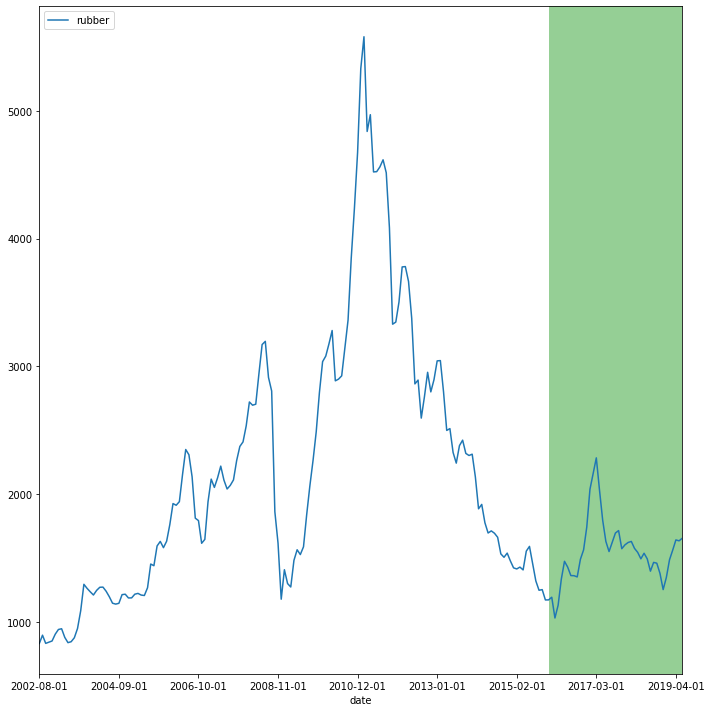

In [157]:
plt.rcParams["figure.figsize"] = (10,10)

pd.merge(train_target, answer_LR,  how='outer').plot('date', 'rubber')

# Rotate and align xtick labels
#ax.get_figure().autofmt_xdate()

# make room for tick labels
plt.tight_layout()
plt.axvspan(160, 204, facecolor='#2ca02c', alpha=0.5)

plt.show()

In [158]:
answer_SGD = pd.DataFrame()
rubber_price_SGD = [pred_list_SGD[i][0] for i in range(0, len(pred_list_SGD))]
answer_SGD = test_target[['date']]
answer_SGD['rubber']=rubber_price_SGD
answer_SGD.round({'rubber': 0}).to_csv('predictedRubberPriceSGD1.csv', sep=',', header=True, index=False)

!cat predictedRubberPriceSGD1.csv
#!more predictedRubberPriceSGD1.csv

date,rubber
2016-01-01,1126.0
2016-02-01,965.0
2016-03-01,1083.0
2016-04-01,1271.0
2016-05-01,1392.0
2016-06-01,1359.0
2016-07-01,1290.0
2016-08-01,1306.0
2016-09-01,1311.0
2016-10-01,1426.0
2016-11-01,1508.0
2016-12-01,1669.0
2017-01-01,1918.0
2017-02-01,2052.0
2017-03-01,2188.0
2017-04-01,1914.0
2017-05-01,1693.0
2017-06-01,1573.0
2017-07-01,1497.0
2017-08-01,1566.0
2017-09-01,1674.0
2017-10-01,1655.0
2017-11-01,1528.0
2017-12-01,1577.0
2018-01-01,1596.0
2018-02-01,1603.0
2018-03-01,1536.0
2018-04-01,1515.0
2018-05-01,1472.0
2018-06-01,1504.0
2018-07-01,1468.0
2018-08-01,1364.0
2018-09-01,1425.0
2018-10-01,1440.0
2018-11-01,1361.0
2018-12-01,1236.0
2019-01-01,1369.0
2019-02-01,1464.0
2019-03-01,1538.0
2019-04-01,1619.0
2019-05-01,1604.0
2019-06-01,1643.0


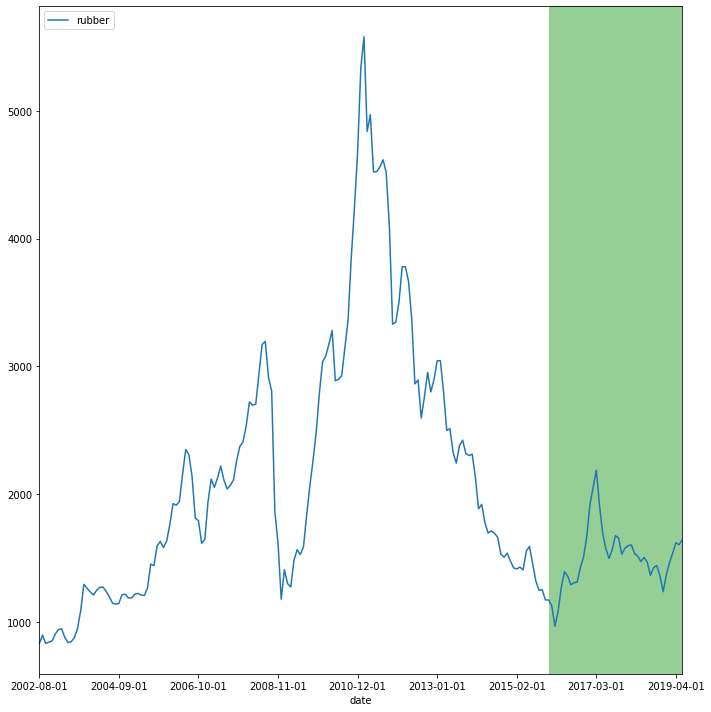

In [159]:
plt.rcParams["figure.figsize"] = (10,10)

pd.merge(train_target, answer_SGD,  how='outer').plot('date', 'rubber')

# Rotate and align xtick labels
#ax.get_figure().autofmt_xdate()

# make room for tick labels
plt.tight_layout()
plt.axvspan(160, 204, facecolor='#2ca02c', alpha=0.5)

plt.show()


In [160]:
answer_GB = pd.DataFrame()
rubber_price_GB = [pred_list_GB[i][0] for i in range(0, len(pred_list_GB))]
answer_GB = test_target[['date']]
answer_GB['rubber']=rubber_price_GB
answer_GB.round({'rubber': 0}).to_csv('predictedRubberPriceGB1.csv', sep=',', header=True, index=False)

!cat predictedRubberPriceGB1.csv
#!more predictedRubberPriceGB1.csv

date,rubber
2016-01-01,1232.0
2016-02-01,1219.0
2016-03-01,1205.0
2016-04-01,1291.0
2016-05-01,1301.0
2016-06-01,1302.0
2016-07-01,1314.0
2016-08-01,1302.0
2016-09-01,1310.0
2016-10-01,1295.0
2016-11-01,1463.0
2016-12-01,1512.0
2017-01-01,1954.0
2017-02-01,2008.0
2017-03-01,2128.0
2017-04-01,1913.0
2017-05-01,1730.0
2017-06-01,1536.0
2017-07-01,1437.0
2017-08-01,1813.0
2017-09-01,2432.0
2017-10-01,2509.0
2017-11-01,2494.0
2017-12-01,2517.0
2018-01-01,2602.0
2018-02-01,2527.0
2018-03-01,2492.0
2018-04-01,2477.0
2018-05-01,2477.0
2018-06-01,2427.0
2018-07-01,2532.0
2018-08-01,2488.0
2018-09-01,2491.0
2018-10-01,2487.0
2018-11-01,2502.0
2018-12-01,2476.0
2019-01-01,2540.0
2019-02-01,2513.0
2019-03-01,2541.0
2019-04-01,2535.0
2019-05-01,2535.0
2019-06-01,2501.0


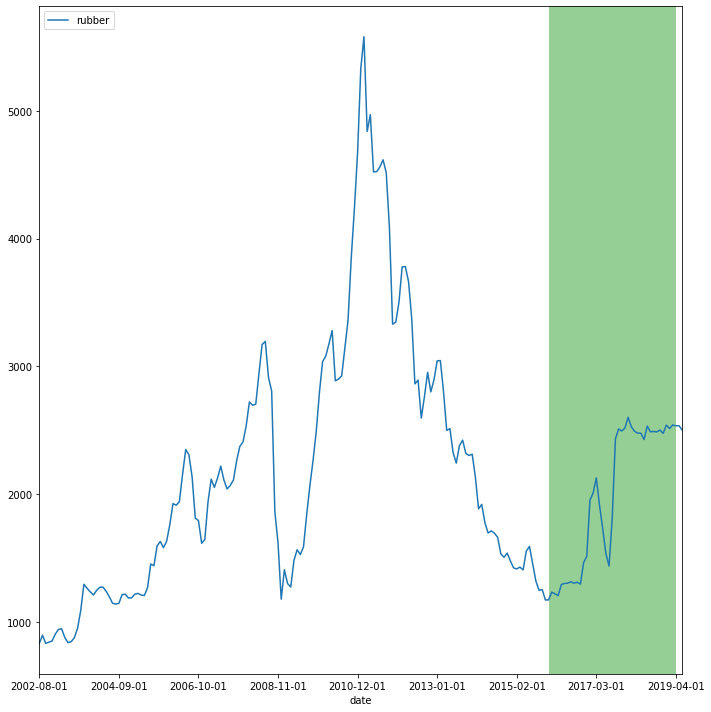

In [161]:
plt.rcParams["figure.figsize"] = (10,10)

pd.merge(train_target, answer_GB,  how='outer').plot('date', 'rubber')

# Rotate and align xtick labels
#ax.get_figure().autofmt_xdate()

# make room for tick labels
plt.tight_layout()
plt.axvspan(160, 200, facecolor='#2ca02c', alpha=0.5)

plt.show()


### За финальный результат принимаем данные predictedRubberPriceSGD1.csv